# Visualize Dynamic Topic Model 1
Update: 05.05.2021<br>
Mai Vu

In [3]:
#Basic libraries
import random
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from collections import defaultdict

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

#Libraries for lemmatization
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#Libraries for (dynamic) topic modeling
import gensim
from gensim import corpora
import pprint
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models import ldaseqmodel
from gensim.models import LdaSeqModel
from gensim.test.utils import datapath

#For plotting
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import plotly.graph_objs as go
import plotly.express as ex
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected = True)
init_notebook_mode(connected = True)

# 1. Init steps

In [4]:
def PlotKeywords_Time(LDAseq_model, num_topic, time, num_word = 8):
    """Function to plot important keywords of all topics in a time slice.
    
    Args:
        (LdaSeqModel) LDAseq_model: the given LDA model.
        (integer) num_topic: number of topics of the model.
        (integer) time: the given time slice.
        (integer) num_word: number of words to plot.

    Returns:
        None.
    """
    dis = LDAseq_model.print_topics(time = time)
    keywords = [[word for word, _ in dis[topicid]] for topicid in range(num_topic)]
    keywords_prob = [[beta for _, beta in dis[topicid]] for topicid in range(num_topic)]

    gs = gridspec.GridSpec(round(math.sqrt(num_topic)) + 1, round(math.sqrt(num_topic)) + 1)
    gs.update(wspace = 0.5, hspace = 0.5)
    plt.figure(figsize = (20, 15))
    for i in range(num_topic):
        ax = plt.subplot(gs[i])
        plt.barh(range(num_word), keywords_prob[i][:num_word])
        ax.invert_yaxis()
        ax.set_yticks(range(num_word))
        ax.set_yticklabels(keywords[i][:num_word])
        plt.grid()
        plt.title("Topic " + str(i + 1))

In [5]:
def PlotKeywords_Topic(LDAseq_model, topic, num_time, num_word = 8):
    """Function to plot important keywords of a topic throughout time.
    
    Args:
        (LdaSeqModel) LDAseq_model: the given LDA model.
        (integer) topic: the given topic's index.
        (integer) num_time: number of total time slices.
        (integer) num_word: number of words to plot.

    Returns:
        None.
    """
    dis = ldaseq_model.print_topic_times(topic = topic)
    keywords = [[word for word, _ in dis[time]] for time in range(num_time)]
    keywords_prob = [[beta for _, beta in dis[time]] for time in range(num_time)]

    gs = gridspec.GridSpec(round(math.sqrt(5)) + 1, round(math.sqrt(5)) + 1)
    gs.update(wspace = 0.5, hspace = 0.5)
    plt.figure(figsize = (20, 15))
    for i in range(num_time):
        ax = plt.subplot(gs[i])
        plt.barh(range(num_word), keywords_prob[i][:num_word])
        ax.invert_yaxis()
        ax.set_yticks(range(num_word))
        ax.set_yticklabels(keywords[i][:num_word])
        plt.grid()
        plt.title("Time " + str(i + 1))

# 2. Read and preprocess the dataset

In [6]:
#Read the data
eng_data = pd.read_csv('eng_abstracts_date+organization.csv')

#Drop a special case
eng_data.drop([eng_data.index[10147]], inplace = True)

#Print samples
eng_data.sample(5)

,date,abstract_en,contributor_organization
6309,2015,This research takes a look at the different wa...,Turku University of Applied Sciences
11195,2017,"The thesis is made for Rec Alkaline Oy, a comp...",Centria University of Applied Sciences
14271,2015,ABSTRACT Susanna Kauppi. Behavior change and c...,Diaconia University of Applied Sciences
12425,2018,This is a project oriented thesis with the obj...,Haaga-Helia University of Applied Sciences
4706,2014,"ABSTRACT Mwose, Juliane. The perception of Fin...",Diaconia University of Applied Sciences


In [7]:
#sort data according to the 'date' column
eng_data.sort_values(by = ['date'])

#Count the number of abstracts in each year
_, time_slices = np.unique(eng_data['date'], return_counts = True)
# 2009 + 2010 + 2011 | 2012 + 2013 | 2014 + 2015 | 2016 + 2017 | 2018 + 2019
time_slices_2years_interval = [time_slices[0] + time_slices[1] + time_slices[2], time_slices[3] + time_slices[4],
                               time_slices[5] + time_slices[6], time_slices[7] + time_slices[8],
                               time_slices[9] + time_slices[10]]
print('Number of documents per time slice:', time_slices_2years_interval)

Number of documents per time slice: [2204, 2994, 3795, 4245, 2319]


In [8]:
#Create eng_stopwords set and lemmatizer from NLTK library
eng_stopwords = set(stopwords.words('english')).union(gensim.parsing.preprocessing.STOPWORDS)
lemmatizer = WordNetLemmatizer()

In [9]:
start_time = time.time() #Start count time

#Tokenization and delete punctuation, number, short words and stop words
allwords_abstracts = []
for abstract in eng_data['abstract_en']:
    tokens = []
    for token in nltk.word_tokenize(abstract.lower()):
        if token.isalpha() and token not in eng_stopwords and len(token) > 3:
            tokens.append(lemmatizer.lemmatize(token))
    allwords_abstracts.append(tokens)

print('- Finish preprocessing data (all words) in', round((time.time() - start_time)/60), 'min(s)')

- Finish preprocessing data (all words) in 1 min(s)


In [10]:
# Build the bigram
bigram = gensim.models.Phrases(allwords_abstracts, min_count = 10, threshold = 10)

In [11]:
for idx in range(len(allwords_abstracts)):
    allwords_abstracts[idx] = bigram[allwords_abstracts[idx]]

In [12]:
#Create dictionary for the given texts
allwords_dictionary = corpora.Dictionary(allwords_abstracts)
allwords_dictionary.filter_extremes(no_below = 10, no_above = 0.25) #Filter words that appear less than 10 documents and more than 25% of all documents
print(allwords_dictionary)

#Create the bag of words for all documents
allwords_bow = [allwords_dictionary.doc2bow(abstract) for abstract in allwords_abstracts]

Dictionary(8922 unique tokens: ['activity', 'actual', 'analyse', 'area', 'book']...)


# 3. Dynamic Topic Modeling

In [ ]:
#(If run) Dynamic Topic Modeling
start_time = time.time() #Start count time
ldaseq = ldaseqmodel.LdaSeqModel(corpus = allwords_bow, id2word = allwords_dictionary, 
                                 time_slice = time_slices_2years_interval, num_topics = 8)
print('- Finish in', round((time.time() - start_time)/60), 'min(s)')

path = datapath('dynamic_model_new')
ldaseq.save(path)

In [13]:
#(Or load) the Dynamic Topic Model
path = datapath('dynamic_model_new')
ldaseq_model = LdaSeqModel.load(path)

# 4. Visualization

## 4.1 The first time slice (2009 - 2010 - 2011) and the last time slice (2018 - 2019)

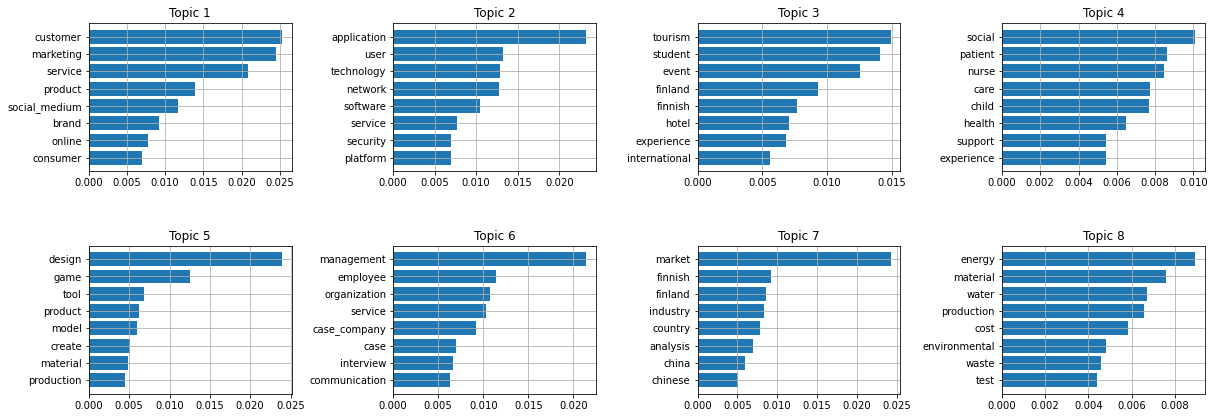

In [14]:
PlotKeywords_Time(ldaseq_model, num_topic = 8, time = 0)

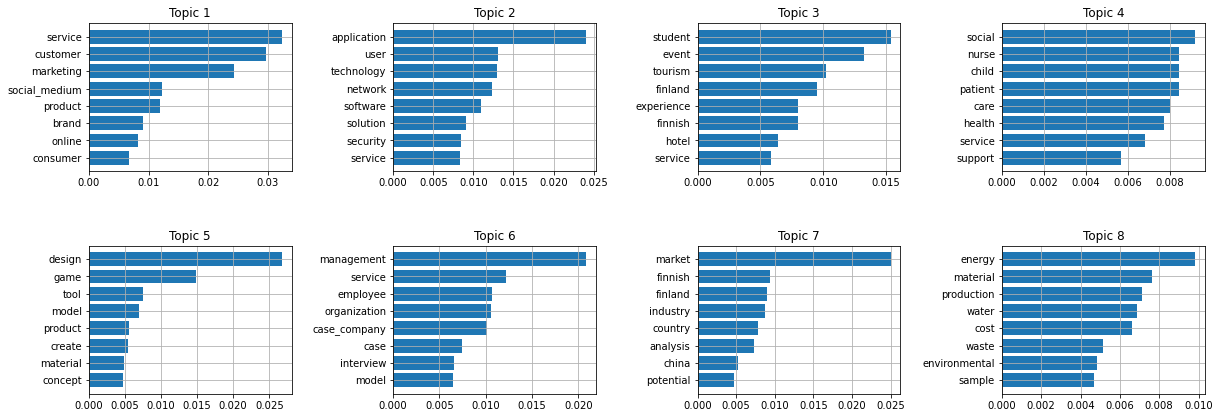

In [19]:
PlotKeywords_Time(ldaseq_model, num_topic = 8, time = 4)

## 4.2 Check some topics through times

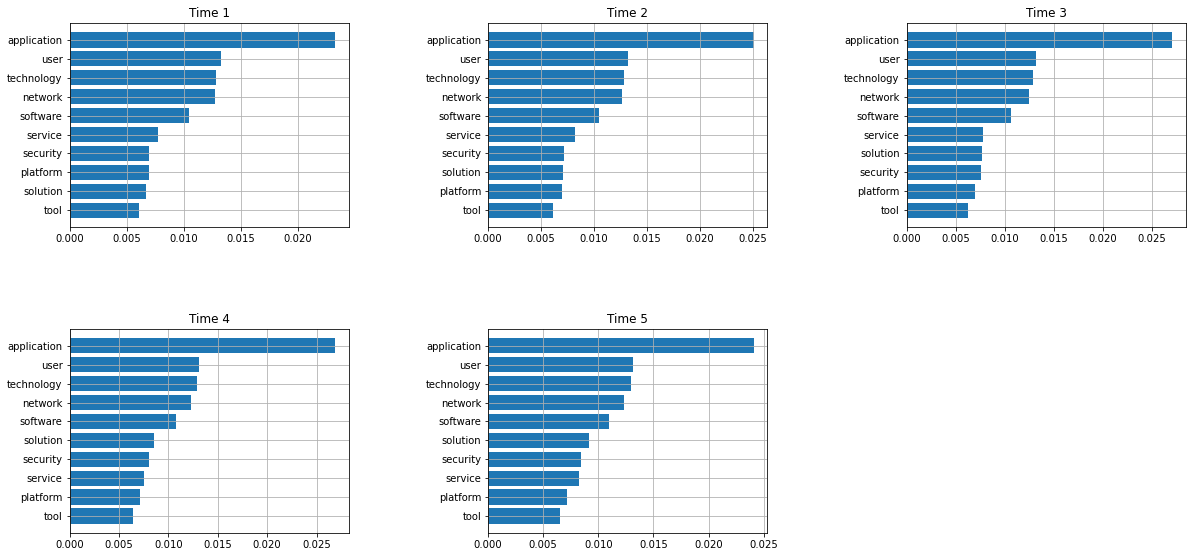

In [16]:
PlotKeywords_Topic(ldaseq_model, topic = 1, num_time = len(time_slices_2years_interval), num_word = 10)

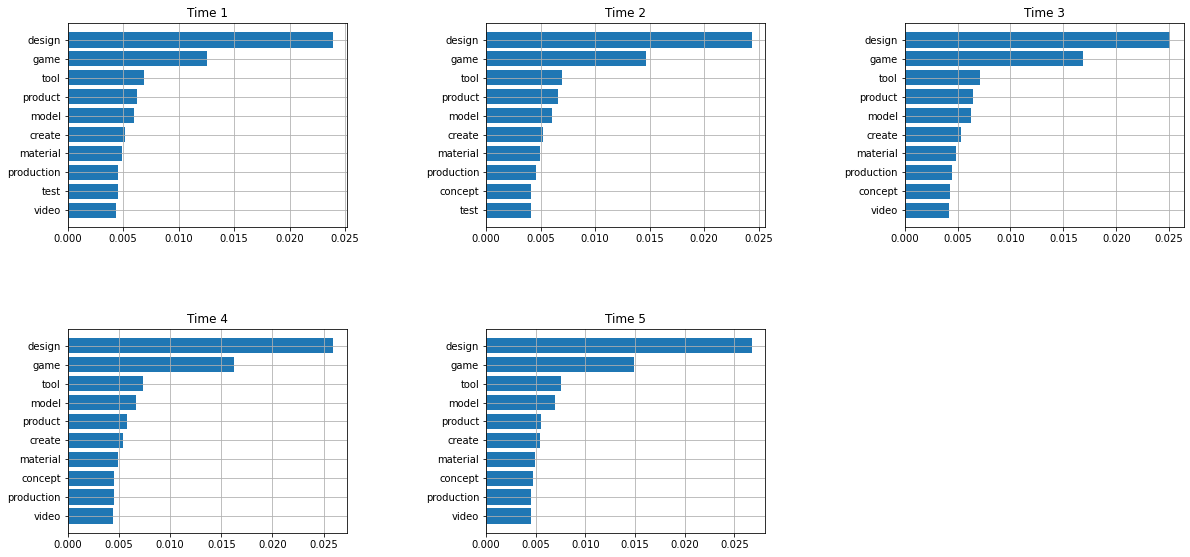

In [17]:
PlotKeywords_Topic(ldaseq_model, topic = 4, num_time = len(time_slices_2years_interval), num_word = 10)

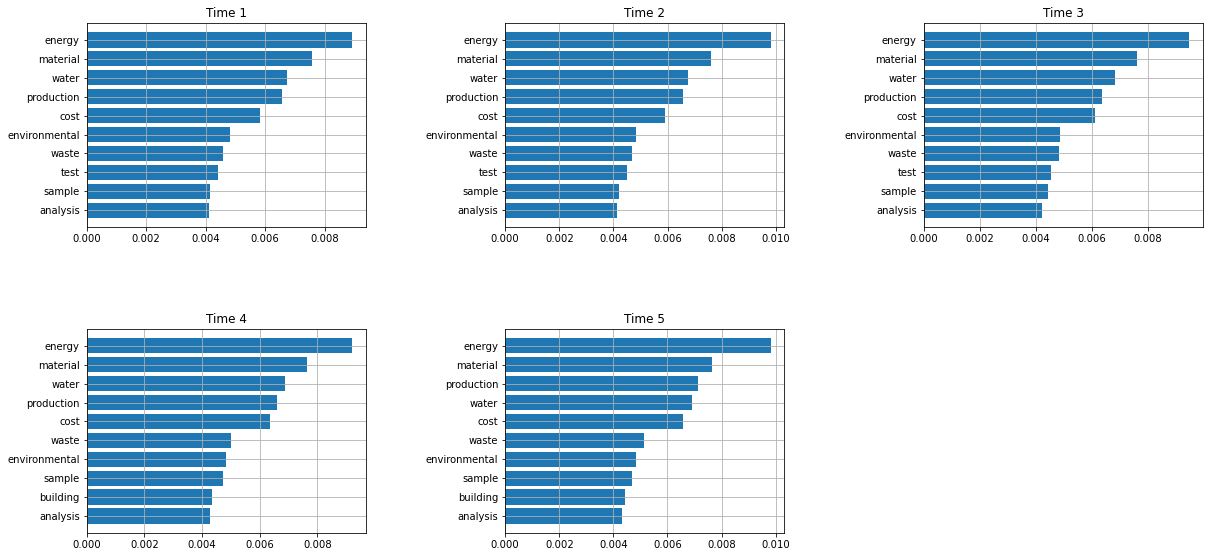

In [18]:
PlotKeywords_Topic(ldaseq_model, topic = 7, num_time = len(time_slices_2years_interval), num_word = 10)